## Classification with Generalized Linear Model



Classification in machine learning and statistics can be generally segregated into two areas:


1.   Binary classification, where the outcome is one of the two or binary.
2.   Multi-class classification, where the outcome is one of the multiple or more than two groups.

We will focus mainly on the three types of classification algorithms employed to multi-class classification

**Support Vector Machines:**
A support vector machine (SVM) is a more flexible type of classification algorithm. You can do linear classification, but also can employ other non-linear functions. The example shown here uses a linear classifier to fit a hyperplane that divides the data into four classes.

**Random Forests:**
Random Forests are an ensemble learning method that fit multiple Decision Trees on subsets of the data and average the results.

**Generalized Linear Models:**
This class of models are in its simplest form, a generalisation of ordinary linear regression for a continous predictor variables given a categorical or continuous response variable. GLMs include Linear Regression, Logistic Regression, ANOVA etc.

Regression analysis is a well-known statistical learning technique useful to infer the relationship between a dependent variable Y and p independent variables [X1, X2, … Xp]. The dependent variable Y is also known as response variable or outcome, and the variables X as predictors, explanatory variables, or covariates.

In a simple Linear Regression Model, the underlying relationship between the dependent variable (value to be predicted) and a group of independent variable (predictors) is linear. Also, the error distribution of the response variable should be normally distributed. The relationship between dependent and independent variable can simply be visualized in the form of a straight line and the simplest case of regression modelling involving a single predictor can be represented as the equation below.

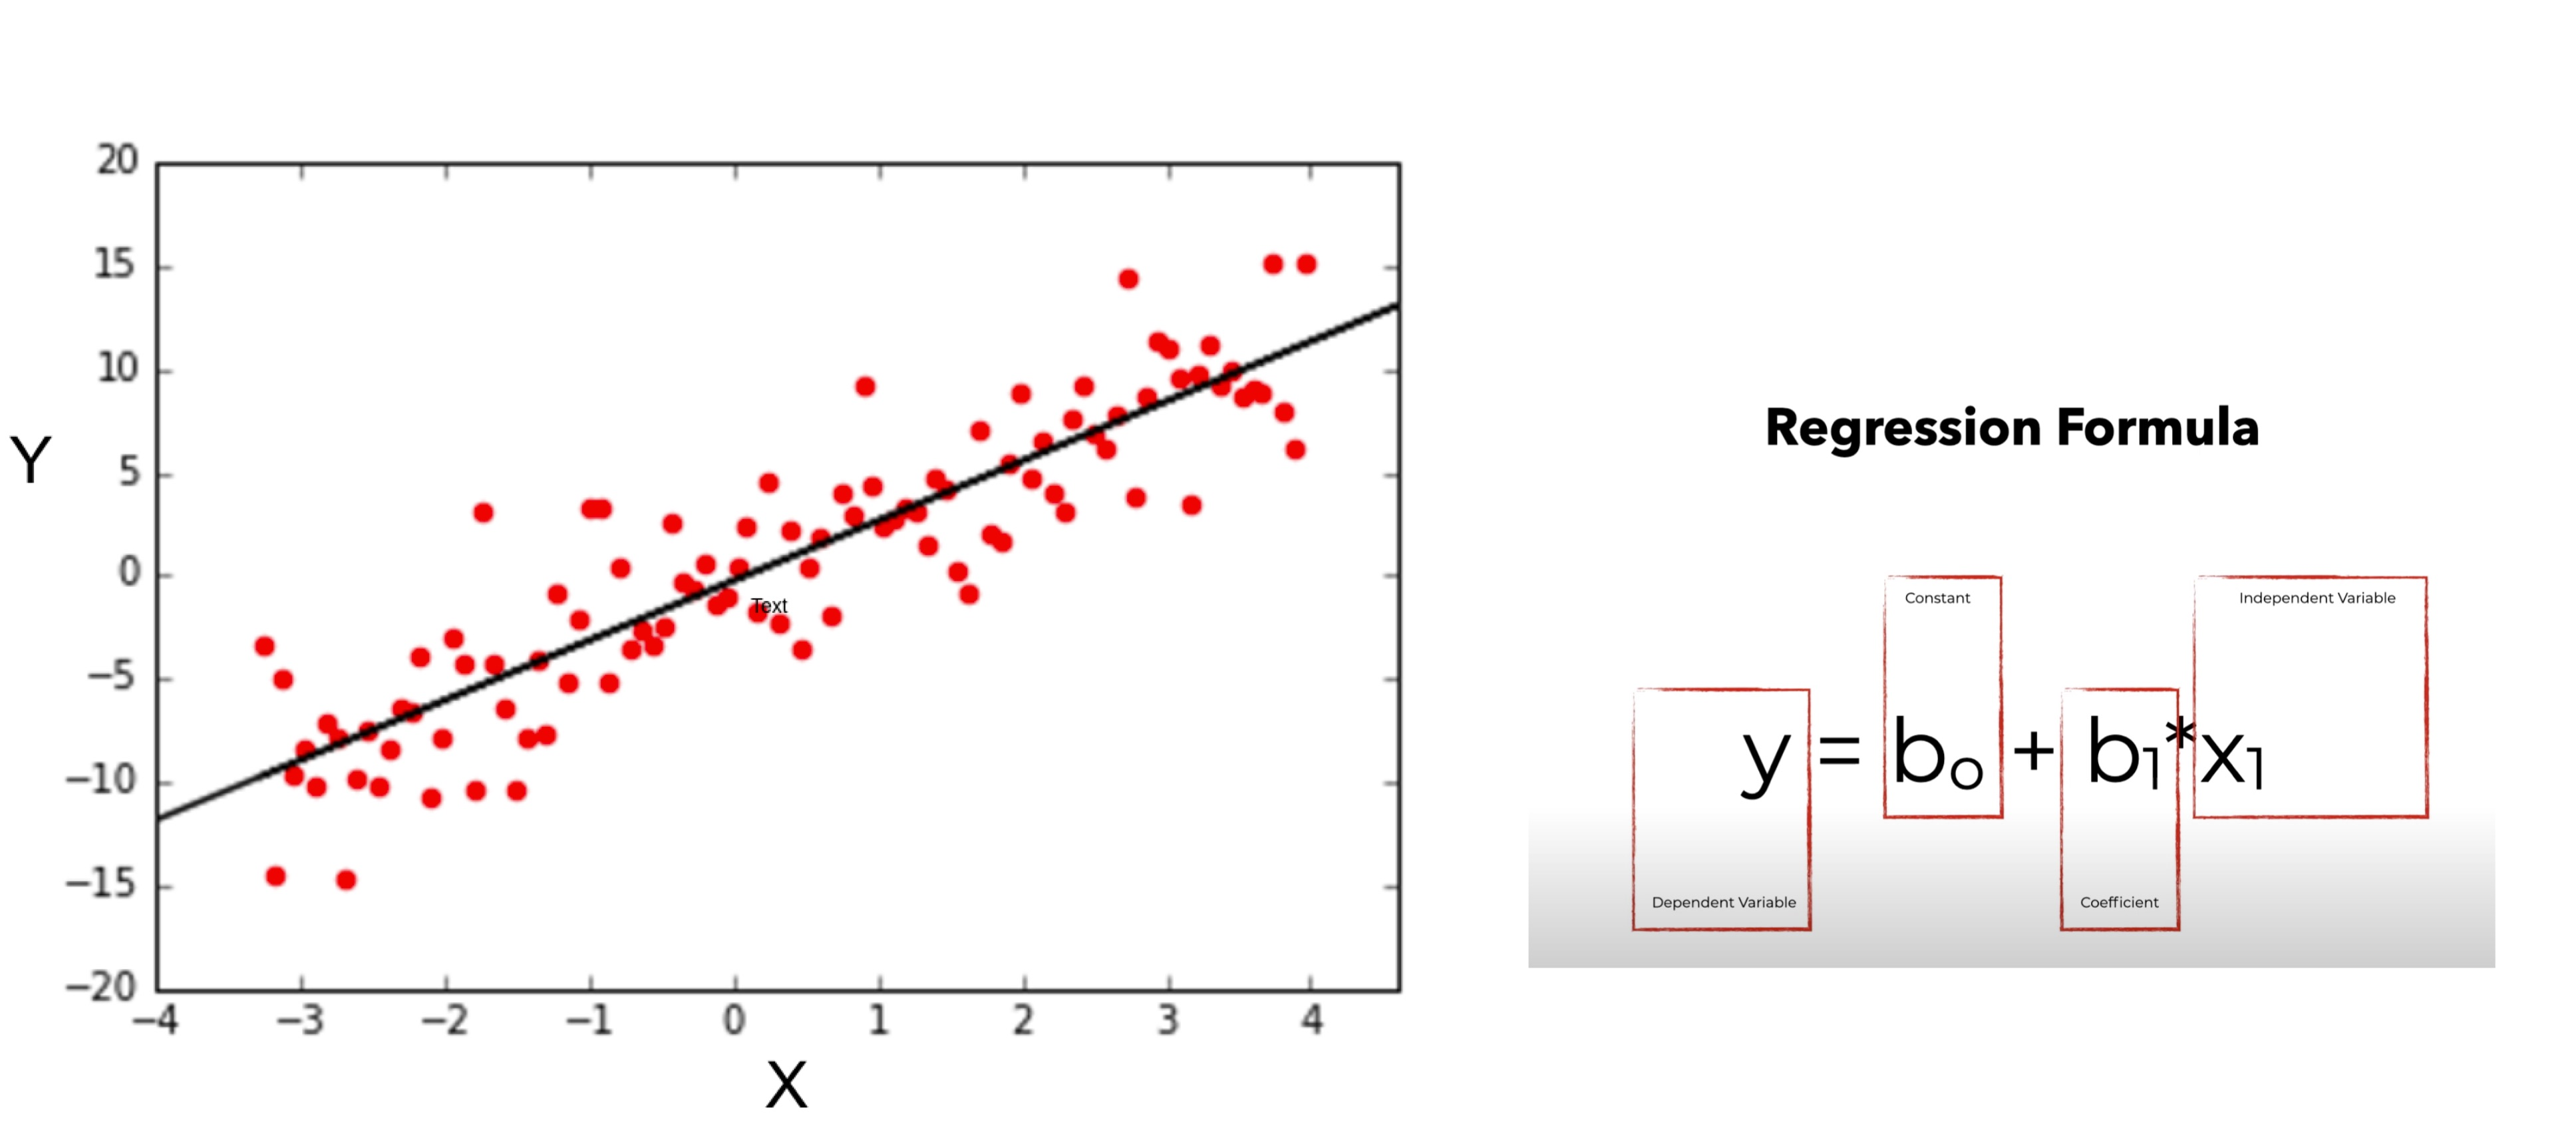

Multiple linear regression extends the above mentioned concepts and formulae to the case where more predictors are used.

Logistic Regression is a type of Generalized Linear Model (GLM) that uses a logistic function to model a binary dependent variable based on any kind and number of independent variables.

The Linear models have these underlying assumptions:

1. At each set of values for the predictors, the response follows a normal distribution.

2. A coefficient vector b defines a linear combination Xb of the predictors X.

3. The error distribution of the response is normally distributed

Advantages of GLMs over traditional regression

1. Data should be independent and random (Each Random variable has the same probability distribution).
2. The response variable y does not need to be normally distributed, but the distribution ought to be one from the exponential family (e.g. binomial, Poisson, multinomial, normal).
3. The original response variable need not be linearly related to the independent variables, but the transformed response variable (through the link function) is linearly dependent on the independent variables
  >e.g., Logistic Regression Equation:                                             
  >Log odds = β0+β1X1+β2X2          
  >where β0,β1,β2 are regression coefficient, and X1,X2 are the independent variables.

5. Errors are independent but need not be normally distributed.



# Performance comparision between Linear Regression, SVM (linearSVC), Random Forest and a GLM classifier based on RF feature selection and various mettrics.





# Load and Prepare Data



The data is loaded and transposed so that the samples are represented as rows while the genes as columns.

In [1]:
# Import packages
import numpy as np
import pandas as pd
# load txt table into python object
data = pd.read_table('/content/GSE202986_normalized_counts.txt',sep='\t',header=(0))

#Prepare the data
#  Get the feature names (first column)
features = data.iloc[1:, 0].values
# Transpose data so the rows are samples and columns are features
dataT = np.transpose(data)
#grab the first row for the header
new_header = dataT.iloc[0]
#take the data less the header row
dataT = dataT[1:]
#set the header row as the df header
dataT.columns = new_header

# First column is sample classes exclude it from the data
X = dataT.iloc[:, 1:].values
y = dataT.iloc[:, 0].values
#get all class names
classes = np.unique(y)

<ipython-input-1-b341dae1edda>:5: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_table('/content/GSE202986_normalized_counts.txt',sep='\t',header=(0))


##Scaling, Train and Test

A simple count at the different class of tumor types revelas the data distribution among them.

In [2]:
# Count the number of samples in each class of Tumour
dataT.iloc[:,0:2].groupby('class').count()


id,TraesCS5D02G061900.1
class,
Mock_inoculated,12
Ptr_inoculated,12
Untreated,12


### Scaling

The SVM and GLM classifiers follow methods based on estimating distances between the train data and test data to classify the later. Hence it becomes necessary to scale all features to comparable ranges, else the features with the largest range will completely dominate in the classification of the test data.

Random forest on the other hand, calculates the probability of the test data to be in one of the target classes, by comparing the test data to the left over (Out of Bounds) data during the training phase. Therefore, this algorithm can work on data that requires little or no preprocessing.

In order to demonstrate the effect of scaling, the distribution of data (from the first 100 genes) corresponding to class are depicted as histogram.

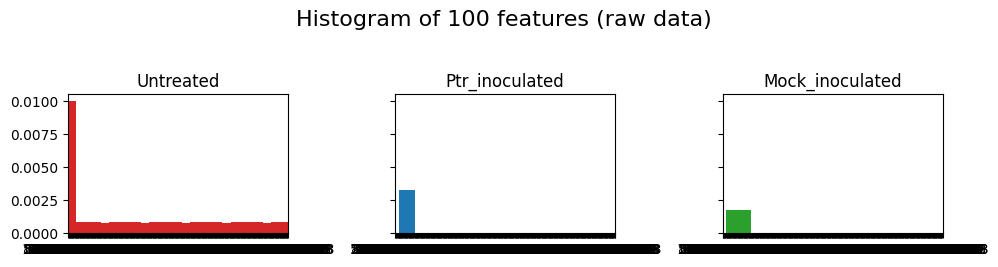

In [4]:
import matplotlib.pyplot as plt

# Histogram of unscaled raw data
# Define the size, number, and colors to be used in the plots
fig, axes = plt.subplots(1, 3, figsize=(10,2.5), dpi=100, sharex=True, sharey=True)
colors = ['tab:red', 'tab:blue','tab:green']

# Looping over different class of tumors, draw the histogram
for i, (ax, tumtype) in enumerate(zip(axes.flatten(), dataT['class'].unique())):
    x = dataT.loc[dataT['class']==tumtype]
    # collect data for first 100 genes
    x = (x.iloc[:, 1:101].values).flatten()
    ax.hist(x, alpha=1, bins=70, density=True, stacked=True, label=str(tumtype), color=colors[i])
    ax.set_title(tumtype)

plt.suptitle('Histogram of 100 features (raw data)', y=1.05, size=16)
ax.set_xlim(0, 400);
#ax.set_ylim(0, 0.05);
plt.tight_layout();

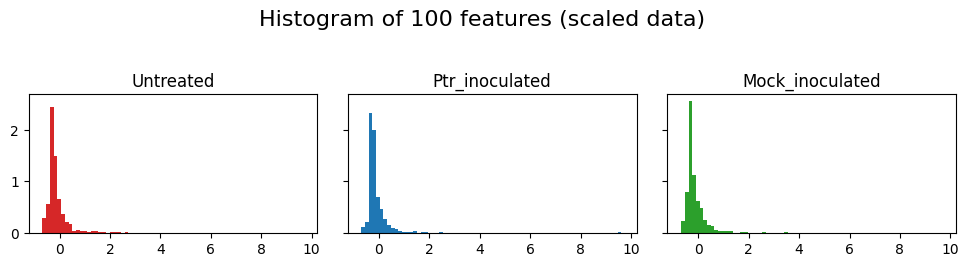

In [5]:
from sklearn.preprocessing import scale
from sklearn import preprocessing

# Histogram of unscaled raw data
# Define the size, number, and colors to be used in the plots
fig, axes = plt.subplots(1, 3, figsize=(10,2.5), dpi=100, sharex=True, sharey=True)
colors = ['tab:red', 'tab:blue','tab:green']

for i, (ax, tumtype) in enumerate(zip(axes.flatten(), dataT['class'].unique())):
    x = dataT.loc[dataT['class']==tumtype]
    # collect data for first 100 genes
    x = scale(x.iloc[:, 1:101].values, axis=1).flatten()
    ax.hist(x, alpha=1, bins=70, density=True, stacked=True, label=str(tumtype), color=colors[i])
    ax.set_title(tumtype)

plt.suptitle('Histogram of 100 features (scaled data)', y=1.05, size=16)
plt.tight_layout();

###Train and Test Data Split

In [6]:
# Import train_test_split and create test and train datasets
from sklearn.model_selection import train_test_split
import collections
# Here test set will be 40% of all data
# Data not scaled since Random Forest can work with unscaled data also
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=15)
display("Train data", collections.Counter(y_train))
display("Test data", collections.Counter(y_test))

'Train data'

Counter({'Untreated': 9, 'Mock_inoculated': 5, 'Ptr_inoculated': 7})

'Test data'

Counter({'Ptr_inoculated': 5, 'Mock_inoculated': 7, 'Untreated': 3})

# Random Forest Classifier

###Random Forest Model

In [7]:
from sklearn.ensemble import RandomForestClassifier
np.random.seed(1234)
model = RandomForestClassifier(n_estimators=500)
# Train the model
model.fit(X_train, y_train)
# Test the model
predictions = model.predict(X_test)

###Accuracy Metrics

**Model Accuracy:** how many class samples were accurately predicted in test data (true positives)

**F1 score:**
The F1 score can be interpreted as a harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 * (precision * recall) / (precision + recall)

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

In [8]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
c_matrix = confusion_matrix(y_test,predictions)
cr = classification_report(y_test,predictions)
model_accuracy = accuracy_score(y_test, predictions)
f1score_rf_all = f1_score(y_test, predictions, average='weighted')

model_accuracy

0.3333333333333333

In [9]:
f1score_rf_all

0.3502645502645502

###Confusion Matrix Plot

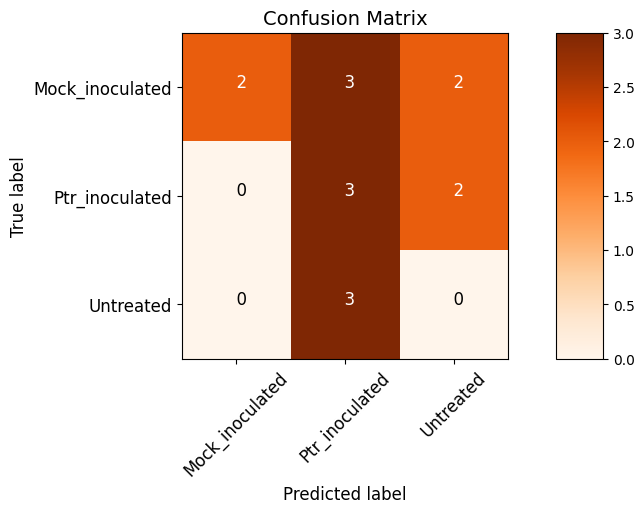

In [10]:
# Plot confusion matrix
plt.figure(figsize = (10, 5))
plt.imshow(c_matrix, cmap=cm.Oranges)
plt.title('Confusion Matrix', size = 14)
plt.colorbar(aspect=7)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, size = 12)
plt.yticks(tick_marks, classes, size = 12)
fmt = '3d'
thresh = c_matrix.max() / 2.


for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
  plt.text(j, i, format(c_matrix[i, j], fmt), fontsize = 12,
        horizontalalignment='center',
        color='white' if c_matrix[i, j] > thresh else 'black')


#plt.grid(None)
plt.tight_layout()
plt.ylabel('True label', size = 12)
plt.xlabel('Predicted label', size = 12)
plt.show()

ROC Curve Plot

The ROC curve as an accuracy metric is primarily defined for binary classification problems. In order to extend it into multinomial classification problems of N classes, the function defines several models iterating over all possible combinations of N.

For instance, depending on the train/test data split, the ROC curves plotted below will not correlate with the confusion matrix above. The reason for this is two-fold.

1.   The components of ROC: true positive rate (TPR) is same as Recall, the false positive rate (FPR) is different from Precision.
2.   To be able to plot ROC curve, a series of probabilities are estimated comparing each class vs the rest in a "One vs Rest" iterations.




In [11]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
# to make roc curve we should binarize our class labels to “one hot” vectors, so each class represent binary vector
# for example: first class = [1, 0, 0, 0], second = [0, 1, 0, 0], ...
y_test_bin_labels = label_binarize(y_test, classes=classes)
# for roc curve we are using predicted proba for our test samples
y_score = model.predict_proba(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin_labels[:, i], y_score[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])
roc_auc_rf_all = roc_auc

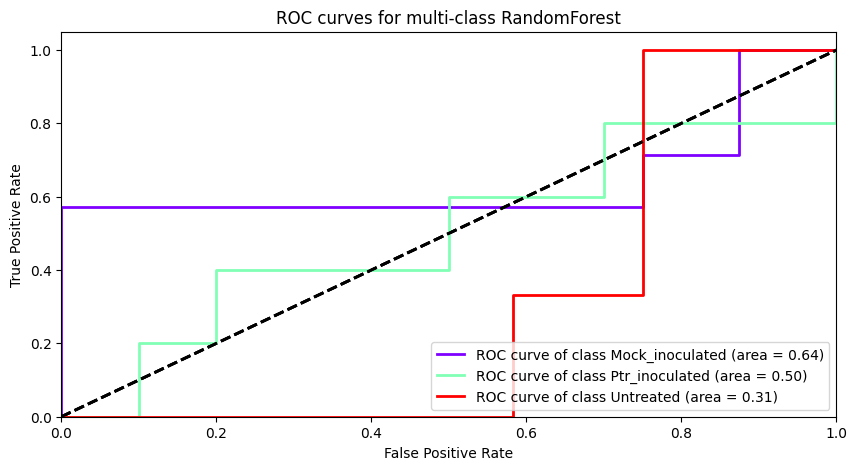

In [12]:
import matplotlib.cm as cm
plt.figure(figsize=(10, 5))
lw = 2
colors = cm.rainbow(np.linspace(0, 1, len(classes)))
for i, color in zip(range(len(classes)), colors):
  plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})' .format(classes[i], roc_auc[i]))
  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate', size=10)
  plt.ylabel('True Positive Rate', size=10)
  plt.title('ROC curves for multi-class RandomForest', size=12)
  plt.legend(loc='lower right')
plt.show()

###Estimate Top Features

In [13]:
#test
# Plot top 30 features.
top_features_count = 30
# Since we use feature_importances reported by Random Forest function, the
# lowest value of importance stops at zero. So the worst features are not
# extracted in this section.
importance = model.feature_importances_
importance = importance[importance>0]
# Sort, retrieve and arrange in descending order the top 30 features
top_coefficients = np.flip(np.argsort(importance)[-top_features_count:])
top_features, top_features_weights = features[top_coefficients], importance[top_coefficients]
top_features

array(['TraesCS3D02G375000.1', 'TraesCS1D02G148800.4',
       'TraesCS6A02G167300.2', 'TraesCS7A02G301000.1',
       'TraesCS4B02G082200.1', 'TraesCS5B02G128800.1',
       'TraesCS6A02G321700.1', 'TraesCS2D02G392800.1',
       'TraesCS5D02G562500.1', 'TraesCS3B02G370700.1',
       'TraesCS6D02G339500.1', 'TraesCS7A02G489900.1',
       'TraesCS7A02G299200.1', 'TraesCS7B02G113500.1',
       'TraesCS1A02G133400.2', 'TraesCS6D02G214200.1',
       'TraesCS6A02G195100.2', 'TraesCS5B02G431100.1',
       'TraesCS5B02G376900.1', 'TraesCS6D02G167200.4',
       'TraesCS3B02G458100.1', 'TraesCS5D02G531800.1',
       'TraesCS5D02G357600.1', 'TraesCS5A02G500700.1',
       'TraesCSU02G191400.1', 'TraesCS2B02G342400.1',
       'TraesCS1D02G278100.1', 'TraesCS3D02G528800.1',
       'TraesCS7A02G017500.1', 'TraesCS5B02G104600.1'], dtype=object)

Plot Top Features

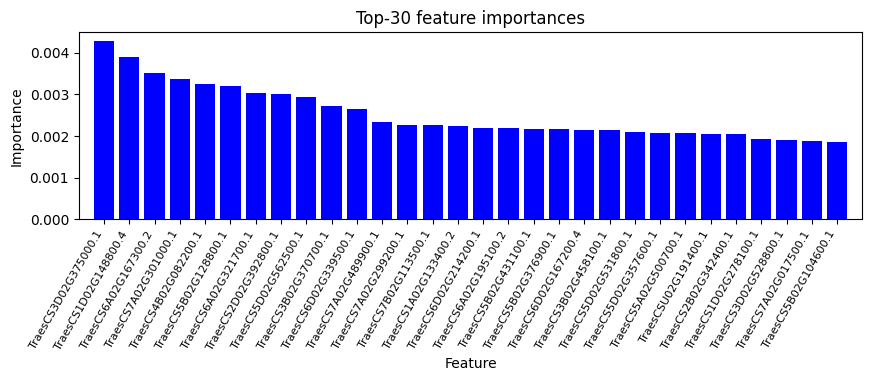

In [14]:
# Plot Top Features
top_features_count = len(top_features)
plt.figure(figsize=(10, 5))
plt.title('Top-{} feature importances'.format(top_features_count), size=12)
colors = ['red' if c < 0 else 'blue' for c in top_features_weights]
plt.bar(np.arange(1, 1 + top_features_count), top_features_weights, color=colors)
plt.xticks(np.arange(1, 1 + top_features_count), top_features, rotation=60, ha='right', size=8)
plt.ylabel('Importance', size=10)
plt.xlabel('Feature', size=10)
plt.xlim([0, top_features_count + 1])
plt.tight_layout(pad=5)
plt.show()

###Selecting Top 1000, 100, 15 features

In [15]:
importance = model.feature_importances_
importance = importance[importance>0]

top_features_count = 15
# Sort, retrieve and arrange in descending order the top 15 features
top_coefficients = np.flip(np.argsort(importance)[-top_features_count:])
top_features, top_features_weights = features[top_coefficients], importance[top_coefficients]
top_features_15 = top_features

top_features_count = 100
# Sort, retrieve and arrange in descending order the top 100 features
top_coefficients = np.flip(np.argsort(importance)[-top_features_count:])
top_features, top_features_weights = features[top_coefficients], importance[top_coefficients]
top_features_100 = top_features

top_features_count = 1000
# Sort, retrieve and arrange in descending order the top 1000 features
top_coefficients = np.flip(np.argsort(importance)[-top_features_count:])
top_features, top_features_weights = features[top_coefficients], importance[top_coefficients]
top_features_1000 = top_features

#Select top 1000 features from Random Forest classifier
X = dataT.loc[:,top_features_1000].values
## Class names remain the same as defined previously.
y = dataT.iloc[:, 0].values
#get all class names.
classes = np.unique(y)

#Import train_test_split and create test and train datasets
# Here test set will be 40% of all data
# Data not scaled since Random Forest can work with unscaled data also
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=15)

display("Train data", collections.Counter(y_train))
display("Test data", collections.Counter(y_test))

X_train_1000 = X_train[:,0:999]
X_test_1000 = X_test[:,0:999]

X_train_100 = X_train[:,0:99]
X_test_100 = X_test[:,0:99]

X_train_15 = X_train[:,0:14]
X_test_15 = X_test[:,0:14]

'Train data'

Counter({'Untreated': 9, 'Mock_inoculated': 5, 'Ptr_inoculated': 7})

'Test data'

Counter({'Ptr_inoculated': 5, 'Mock_inoculated': 7, 'Untreated': 3})

##Random Forest Classifier with top 15, 100, 1000 features

###Introduction

The performance of Random forest classifier for a selected number (15, 100, 1000) of top features is a repetetive process. Hence, the individual sections of code required to train, test the RF model and generate the plots are combined into a function. This function can be called upon to execute the same code for selected number of top features.

The top 15, 100 and 1000 feature selected through Random forest classifier is used as a limited dataset to evaluate the performance of Random forest, SVM and GLM classifiers.

###Function definition

In [16]:
#Import packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.cm as cm

#Define the function that tests the Random Forest classifier trained on selected
#features and returns the ROC
def RF_model_feature_selection(X_train, X_test):

  # Define the Random forest classifier
  np.random.seed(1234)
  model = RandomForestClassifier(n_estimators=500)
  # Train the model
  model.fit(X_train, y_train)
  # Test the model
  predictions = model.predict(X_test)

  #Accuracy Metrics
  c_matrix = confusion_matrix(y_test,predictions)
  cr = classification_report(y_test,predictions)
  model_accuracy = accuracy_score(y_test, predictions)
  f1score = f1_score(y_test, predictions, average='weighted')

  #Plot confusion matrix
  plt.figure(figsize = (10, 5))
  plt.imshow(c_matrix, cmap=cm.Oranges)
  plt.title('Confusion Matrix', size = 14)
  plt.colorbar(aspect=7)
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45, size = 12)
  plt.yticks(tick_marks, classes, size = 12)
  fmt = '3d'
  thresh = c_matrix.max() / 2.


  for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
    plt.text(j, i, format(c_matrix[i, j], fmt), fontsize = 12,
          horizontalalignment='center',
          color='white' if c_matrix[i, j] > thresh else 'black')


  plt.tight_layout()
  plt.ylabel('True label', size = 12)
  plt.xlabel('Predicted label', size = 12)
  plt.show()

  # to make roc curve we should binarize our class labels to “one hot” vectors, so each class represent binary vector
  # for example: first class = [1, 0, 0, 0], second = [0, 1, 0, 0], ...
  y_test_bin_labels = label_binarize(y_test, classes=classes)
  # for roc curve we are using predicted proba for our test samples
  y_score = model.predict_proba(X_test)
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin_labels[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


  plt.figure(figsize=(10, 5))
  lw = 2
  colors = cm.rainbow(np.linspace(0, 1, len(classes)))
  for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})' .format(classes[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=10)
    plt.ylabel('True Positive Rate', size=10)
    plt.title('ROC curves for multi-class RandomForest', size=12)
    plt.legend(loc='lower right')
  plt.show()

  return roc_auc, f1score, model_accuracy

###Random Forest with top 15 features

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


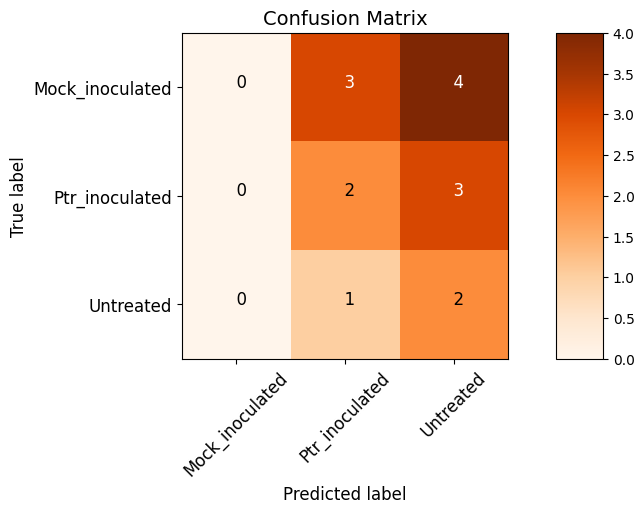

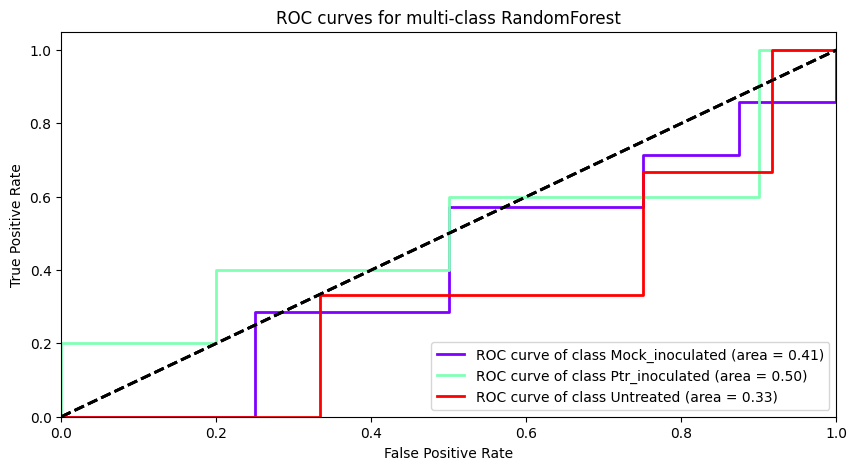

In [17]:
# Call the function by passing top 15 features and store the roc value separately
roc_auc_rf_15, f1score_rf_15, model_accuracy_rf_15 = RF_model_feature_selection(X_train_15, X_test_15)
#roc_auc_rf_15

In [18]:
f1score_rf_15

0.1878787878787879

In [19]:
model_accuracy_rf_15

0.26666666666666666

###Random Forest with top 100 features


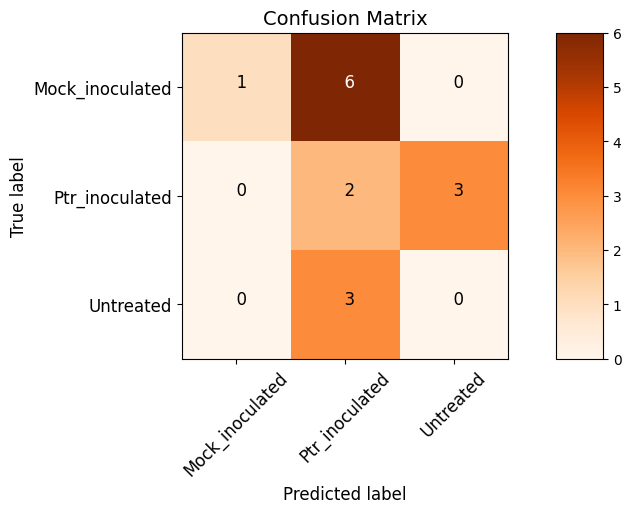

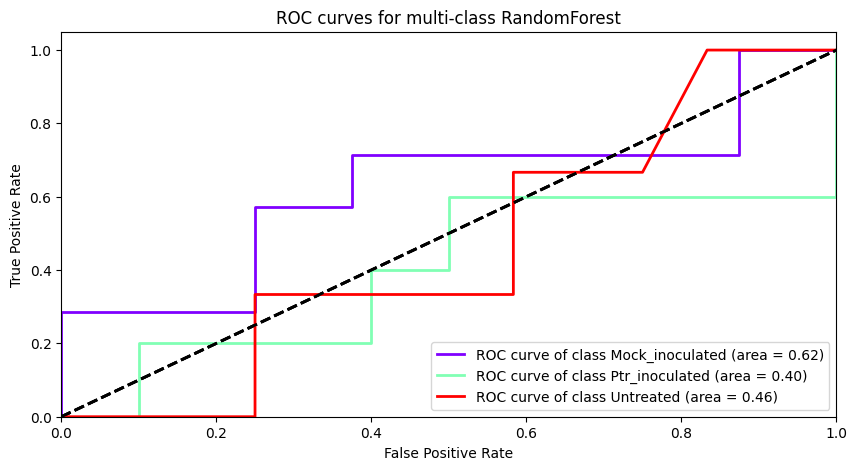

In [20]:
# Call the function by passing top 10 features and store the roc value separately
roc_auc_rf_100, f1score_rf_100, model_accuracy_rf_100 = RF_model_feature_selection(X_train_100, X_test_100)
#roc_auc_rf_100

In [21]:
f1score_rf_100

0.2

In [22]:
model_accuracy_rf_100

0.2

###Random Forest with top 1000 features


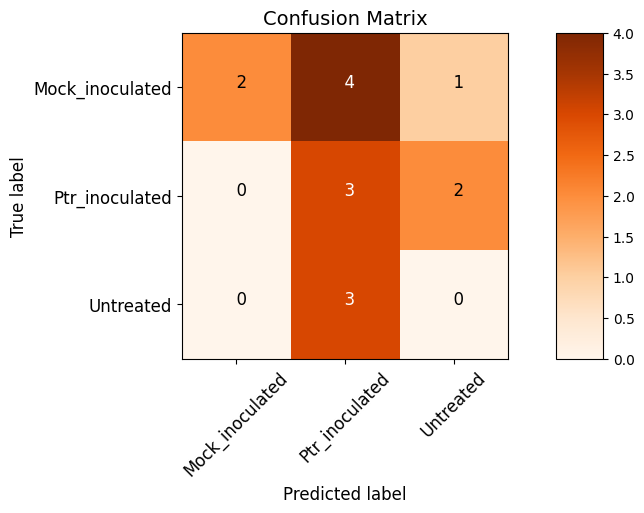

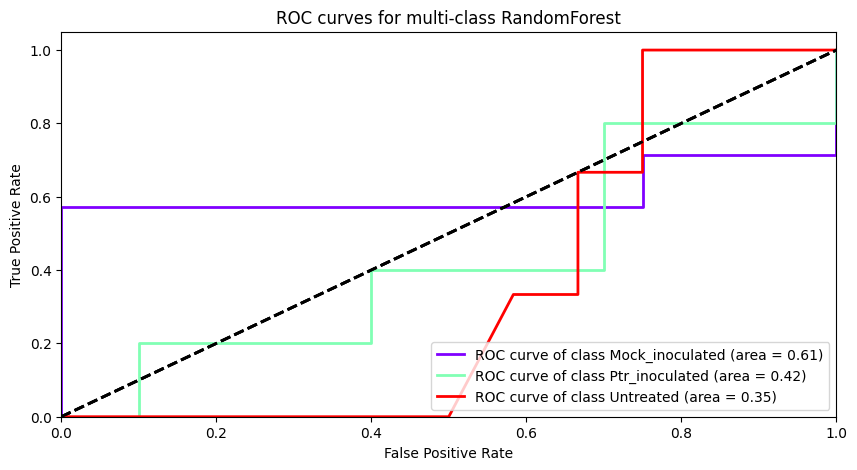

In [23]:
# Call the function by passing top 10 features and store the roc value separately
roc_auc_rf_1000, f1score_rf_1000, model_accuracy_rf_1000 = RF_model_feature_selection(X_train_1000, X_test_1000)
#roc_auc_rf_1000

In [24]:
f1score_rf_1000

0.34074074074074073

In [25]:
model_accuracy_rf_1000

0.3333333333333333

# Linear Regression

### Preprocessing labels

For linear regression, which works as a binary classifier only, the class names should be loaded as integers. To convert the names to integers, new data for train and test is prepared.

In [26]:
# Convert the text based classes into integer labels as required by Linear Regression.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(classes)
display(classes, "Encoded as", le.transform(classes))
y_train_int = le.transform(y_train)
y_test_int = le.transform(y_test)

# Scaling is performed on the training and test data
X_train = scale(X_train, axis=1)
X_test = scale(X_test, axis=1)


array(['Mock_inoculated', 'Ptr_inoculated', 'Untreated'], dtype=object)

'Encoded as'

array([0, 1, 2])

### Linear Regression Model

In [27]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import label_binarize

lin_regression = LinearRegression()
reg = lin_regression.fit(X_train, y_train_int)

# Return the coefficient of determination of prediction
display ("The coefficient of determination - R2 score", reg.score(X_train, y_train_int), "-------------")

# Regression coefficients for first 10 feature
display ("The Regression Coefficients of first 10 features", reg.coef_[0:10], "-------------")

# The intercept of the Regression fit
display ("The intercept", reg.intercept_, "-------------")

'The coefficient of determination - R2 score'

1.0

'-------------'

'The Regression Coefficients of first 10 features'

array([-0.03842521,  0.00916538, -0.0923895 ,  0.06589116, -0.00539883,
       -0.03427163, -0.01750423,  0.01556119,  0.04555941,  0.01112081])

'-------------'

'The intercept'

-0.4438497748942378

'-------------'

Regresion coefficient is the "weight" of each variable in the regression model, which means each "gene" has a coefficient "b" in the "bxₙ" part of the regression model. The coefficients for all genes x are normally distributed and centered around 0. The intercept is where the regression line crosses the y axis at x=0.

##Confusion Matrix Plot

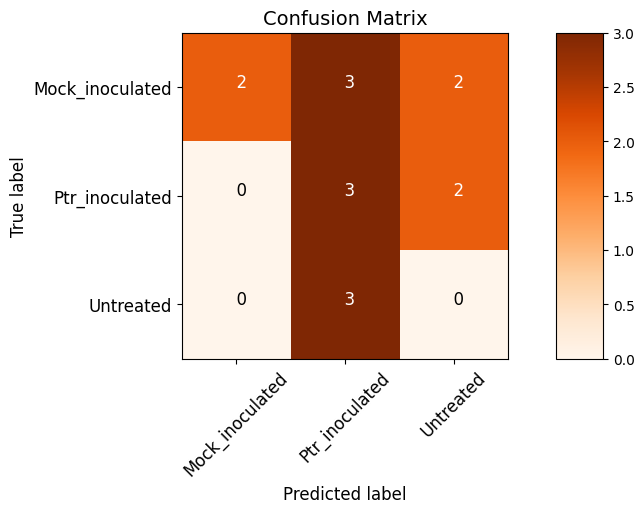

In [31]:
# Plot confusion matrix
plt.figure(figsize = (10, 5))
plt.imshow(c_matrix, cmap=cm.Oranges)
plt.title('Confusion Matrix', size = 14)
plt.colorbar(aspect=7)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, size = 12)
plt.yticks(tick_marks, classes, size = 12)
fmt = '3d'
thresh = c_matrix.max() / 2.


for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
  plt.text(j, i, format(c_matrix[i, j], fmt), fontsize = 12,
        horizontalalignment='center',
        color='white' if c_matrix[i, j] > thresh else 'black')


#plt.grid(None)
plt.tight_layout()
plt.ylabel('True label', size = 12)
plt.xlabel('Predicted label', size = 12)
plt.show()

##ROC Curve

Linear Regression prediction is a continuous variable, not a probability of classification, ROC and AUC can not be calculated.

##Linear Regression with top 15, 100, 1000 features

### Introduction

Similar to Random forest classifier, the repetetive calculations of Linear Regression is also coded as a function. This function is called multiple times to evaluate the classifier's performance for a top (15, 100, 1000) features selected by Random forest classifier.

###Function definition

In [32]:
#Import packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.cm as cm


#Define the function that estimates the Linear Regression for selected data
#features and returns the ROC
def lin_reg_model_feature_selection(X_train, X_test):

  # Convert the text based classes into integer labels as required by Linear Regression.
  from sklearn import preprocessing
  le = preprocessing.LabelEncoder()
  le.fit(classes)
  display(classes, "Encoded as", le.transform(classes))
  y_train_int = le.transform(y_train)
  y_test_int = le.transform(y_test)

  # Scaling is performed on the training and test data
  X_train = scale(X_train, axis=1)
  X_test = scale(X_test, axis=1)

  # Linear Regression Model
  from sklearn.linear_model import LinearRegression
  from sklearn.preprocessing import label_binarize

  lin_regression = LinearRegression()
  reg = lin_regression.fit(X_train, y_train_int)

  # Return the coefficient of determination of prediction
  display ("The coefficient of determination - R2 score", reg.score(X_train, y_train_int), "-------------")

  # Regression coefficients for first 10 feature
  display ("The Regression Coefficients of first 10 features", reg.coef_[1:10], "-------------")

  # The intercept of the Regression fit
  display ("The intercept", reg.intercept_, "-------------")

  # Test the model
  predictions = lin_regression.predict(X_test)
  #predictions
  # Convert the predictions to integer values and then inverse transform back to type of cancer
  predictions = le.inverse_transform(np.clip(np.abs((np.round_(predictions, decimals = 0, out = None).astype(int))),0,3))

  c_matrix = confusion_matrix(y_test,predictions)
  cr = classification_report(y_test,predictions)
  model_accuracy = accuracy_score(y_test, predictions)
  f1score = f1_score(y_test, predictions, average='weighted')

  # Plot confusion matrix
  plt.figure(figsize = (10, 5))
  plt.imshow(c_matrix, cmap=cm.Oranges)
  plt.title('Confusion Matrix', size = 14)
  plt.colorbar(aspect=7)
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45, size = 12)
  plt.yticks(tick_marks, classes, size = 12)
  fmt = '3d'
  thresh = c_matrix.max() / 2.


  for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
    plt.text(j, i, format(c_matrix[i, j], fmt), fontsize = 12,
          horizontalalignment='center',
          color='white' if c_matrix[i, j] > thresh else 'black')


  #plt.grid(None)
  plt.tight_layout()
  plt.ylabel('True label', size = 12)
  plt.xlabel('Predicted label', size = 12)
  plt.show()
  return 1, f1score, model_accuracy

###Linear Regression with top 1000 features


array(['Mock_inoculated', 'Ptr_inoculated', 'Untreated'], dtype=object)

'Encoded as'

array([0, 1, 2])

'The coefficient of determination - R2 score'

1.0

'-------------'

'The Regression Coefficients of first 10 features'

array([ 0.01684818, -0.06697276,  0.00816158, -0.00499075, -0.0114532 ,
       -0.01217837,  0.00858906,  0.02795066, -0.00634928])

'-------------'

'The intercept'

-0.5350020165095439

'-------------'

<ipython-input-64-a1689bf2dbb6>:2: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  roc_auc_lin_reg_1000, f1score_lin_reg_1000, model_accuracy_lin_reg_1000 = lin_reg_model_feature_selection(X_train_1000, X_test_1000)


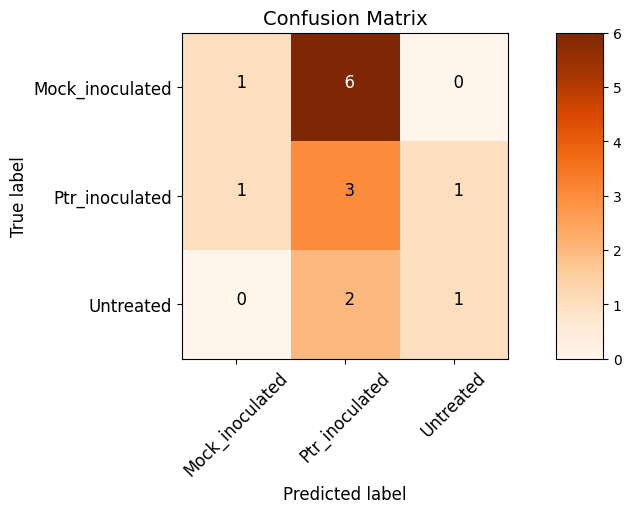

In [64]:
# Call the function by passing top 1000 features and store the roc value separately
roc_auc_lin_reg_1000, f1score_lin_reg_1000, model_accuracy_lin_reg_1000 = lin_reg_model_feature_selection(X_train_1000, X_test_1000)
#roc_auc_lin_reg_1000

# Suppor Vector Machine (SVM) Classifier

### Scale the data

In [36]:
# Scale the data
from sklearn import preprocessing
# Scaling is performed on the training and test data
X_train = scale(X_train, axis=1)
X_test = scale(X_test, axis=1)


###SVM (linear) model

In [37]:
#import model class (SVC stands for Support Vector Classification)
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
# Linear Kernel
## Create the model
model = SVC(kernel="linear", probability=True, random_state=9999)
# Train the model
model.fit(X_train, y_train)
# Test the model
predictions = model.predict(X_test)
predictions

array(['Untreated', 'Ptr_inoculated', 'Ptr_inoculated', 'Mock_inoculated',
       'Ptr_inoculated', 'Ptr_inoculated', 'Untreated', 'Ptr_inoculated',
       'Ptr_inoculated', 'Untreated', 'Mock_inoculated', 'Ptr_inoculated',
       'Ptr_inoculated', 'Mock_inoculated', 'Mock_inoculated'],
      dtype=object)

###Accuracy Metrics

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
c_matrix = confusion_matrix(y_test,predictions)
cr = classification_report(y_test,predictions)
model_accuracy = accuracy_score(y_test, predictions)
f1score_svm_all = f1_score(y_test, predictions, average="weighted")

###Confusion Matrix Plot

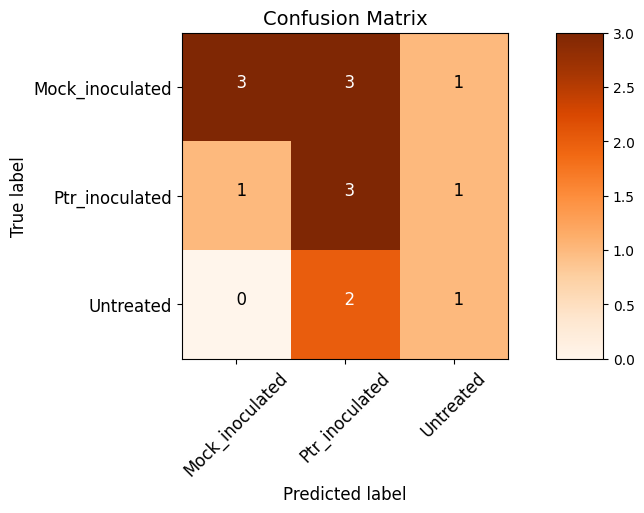

In [39]:
# Plot confusion matrix
plt.figure(figsize = (10, 5))
plt.imshow(c_matrix, cmap=cm.Oranges)
plt.title('Confusion Matrix', size = 14)
plt.colorbar(aspect=7)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, size = 12)
plt.yticks(tick_marks, classes, size = 12)
fmt = '3d'
thresh = c_matrix.max() / 2.


for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
  plt.text(j, i, format(c_matrix[i, j], fmt), fontsize = 12,
        horizontalalignment='center',
        color='white' if c_matrix[i, j] > thresh else 'black')


#plt.grid(None)
plt.tight_layout()
plt.ylabel('True label', size = 12)
plt.xlabel('Predicted label', size = 12)
plt.show()

###ROC Curve

In [40]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
# to make roc curve we should binarize our class labels to “one hot” vectors, so each class represent binary vector
# for example: first class = [1, 0, 0, 0], second = [0, 1, 0, 0], ...
y_test_bin_labels = label_binarize(y_test, classes=classes)
# for roc curve we are using predicted probability for our test samples
y_score = model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin_labels[:, i], y_score[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])
roc_auc_svm_all = roc_auc


ROC Curve Plot


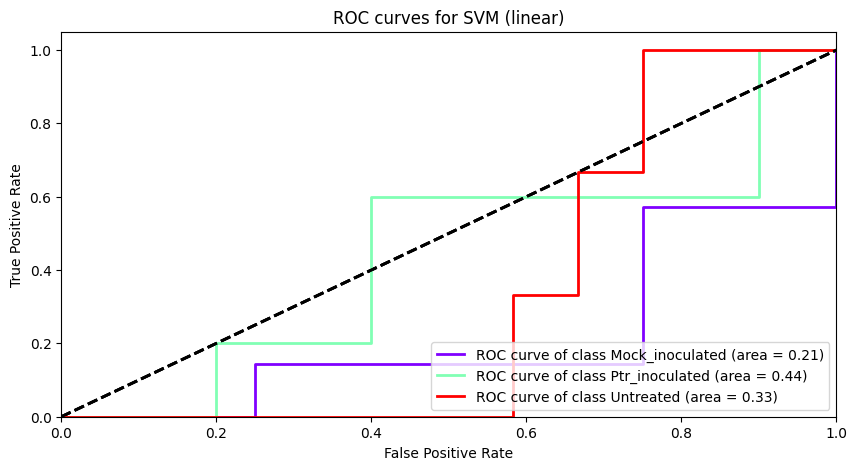

In [41]:
import matplotlib.cm as cm
plt.figure(figsize=(10, 5))
lw = 2
colors = cm.rainbow(np.linspace(0, 1, len(classes)))
for i, color in zip(range(len(classes)), colors):
  plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})' .format(classes[i], roc_auc[i]))
  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate', size=10)
  plt.ylabel('True Positive Rate', size=10)
  plt.title('ROC curves for SVM (linear)', size=12)
  plt.legend(loc='lower right')
plt.show()

##SVM with top 10, 30, 100, 1000 features

###Introduction

Similar to Random forest classifier, the repetetive calculations of SVM classifier is also coded as a function. This function is called multiple times to evaluate the classifier's performance for a top (15, 100, 1000) features selected by Random forest classifier.

###Function definition

In [42]:
#Import packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.cm as cm


#Define the function that tests the SVM classifier trained on selected features
#and returns the ROC
def SVM_model_feature_selection(X_train, X_test):

  # Scaling is performed on the training and test data
  X_train = scale(X_train, axis=1)
  X_test = scale(X_test, axis=1)

  # Linear Kernel
  #model = LinearSVC(C=1.0)
  model = SVC(kernel="linear", probability=True, random_state=9999)
  # Train the model
  model.fit(X_train, y_train)
  # Test the model
  predictions = model.predict(X_test)
  predictions

  #Accuracy Metrics
  c_matrix = confusion_matrix(y_test,predictions)
  cr = classification_report(y_test,predictions)
  model_accuracy = accuracy_score(y_test, predictions)
  f1score = f1_score(y_test, predictions, average='weighted')

  #Plot Confusion matrix
  plt.figure(figsize = (10, 5))
  plt.imshow(c_matrix, cmap=cm.Oranges)
  plt.title('Confusion Matrix', size = 14)
  plt.colorbar(aspect=7)
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45, size = 12)
  plt.yticks(tick_marks, classes, size = 12)
  fmt = '3d'
  thresh = c_matrix.max() / 2.


  for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
    plt.text(j, i, format(c_matrix[i, j], fmt), fontsize = 12,
          horizontalalignment='center',
          color='white' if c_matrix[i, j] > thresh else 'black')


  #plt.grid(None)
  plt.tight_layout()
  plt.ylabel('True label', size = 12)
  plt.xlabel('Predicted label', size = 12)
  plt.show()

  # to make roc curve we should binarize our class labels to “one hot” vectors, so each class represent binary vector
  # for example: first class = [1, 0, 0, 0], second = [0, 1, 0, 0], ...
  y_test_bin_labels = label_binarize(y_test, classes=classes)
  # for roc curve we are using predict probability for our test samples
  y_score = model.predict_proba(X_test)
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin_labels[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  #roc_auc_svm_30 = roc_auc

  plt.figure(figsize=(10, 5))
  lw = 2
  colors = cm.rainbow(np.linspace(0, 1, len(classes)))
  for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})' .format(classes[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=10)
    plt.ylabel('True Positive Rate', size=10)
    plt.title('ROC curves for SVM (linear)', size=12)
    plt.legend(loc='lower right')
  plt.show()
  return roc_auc, f1score

###SVM with top 15 features

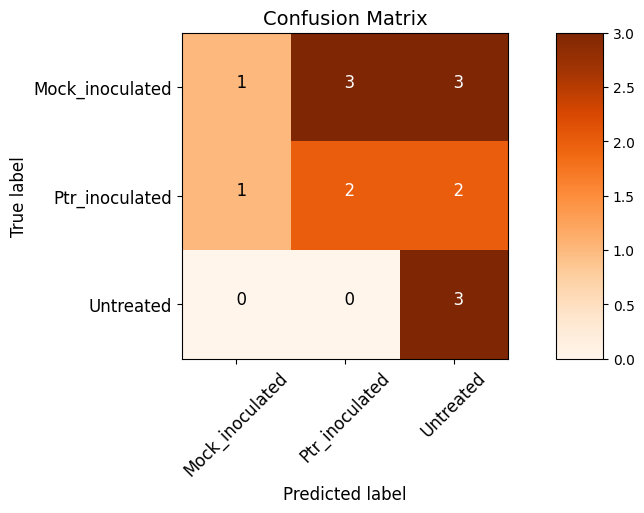

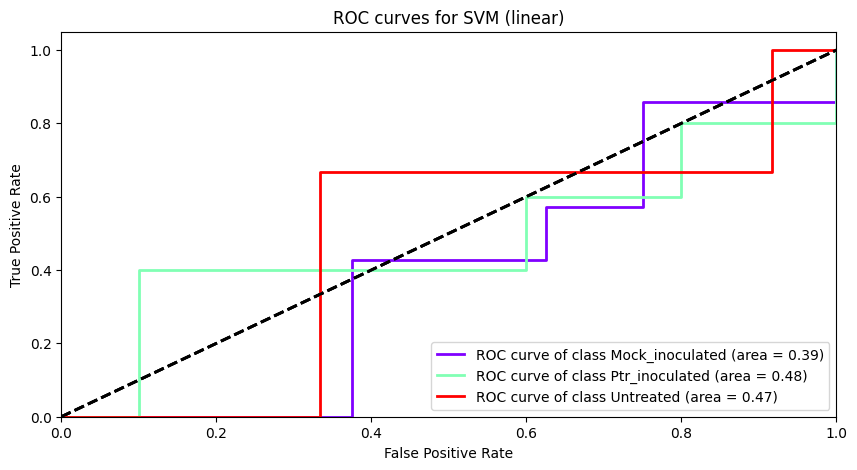

In [43]:
# Call the function by passing top 15 features and store the roc value separately
roc_auc_svm_15, f1score_svm_15 = SVM_model_feature_selection(X_train_15, X_test_15)
#roc_auc_svm_15

###SVM with top 100 features

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


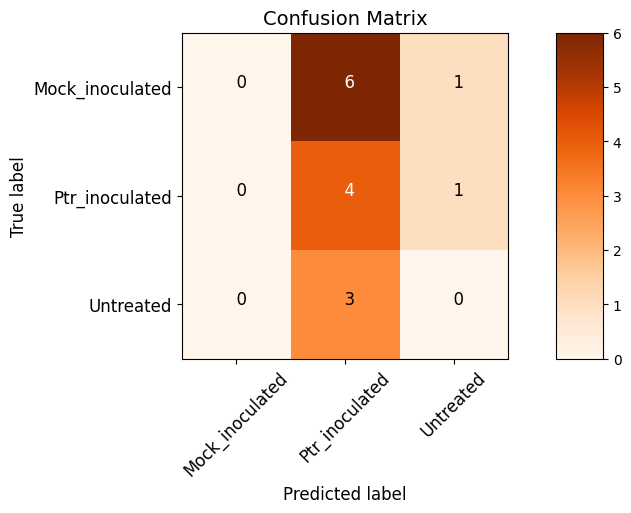

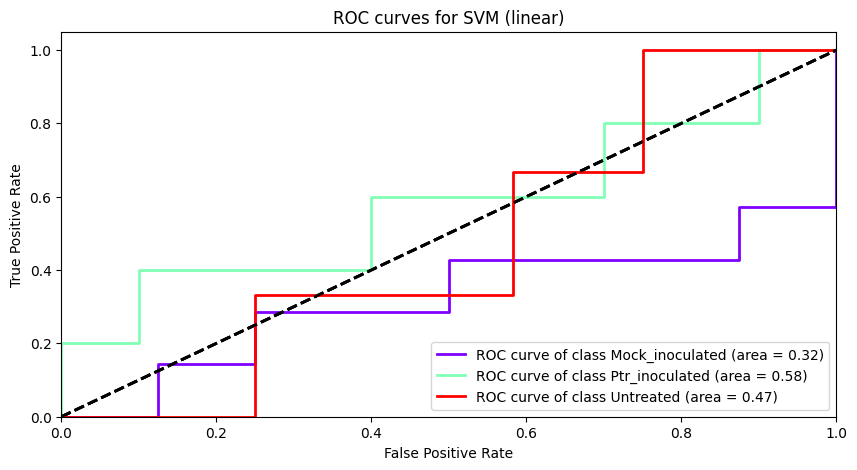

In [44]:
# Call the function by passing top 100 features and store the roc value separately
roc_auc_svm_100, f1score_svm_100 = SVM_model_feature_selection(X_train_100, X_test_100)
#roc_auc_svm_100

###SVM with top 1000 features

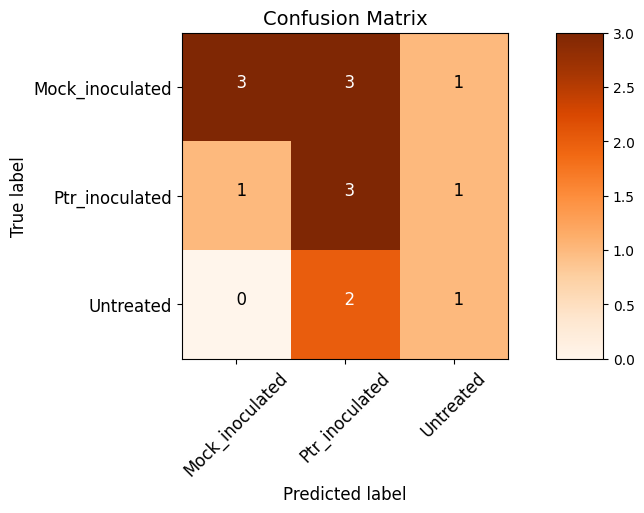

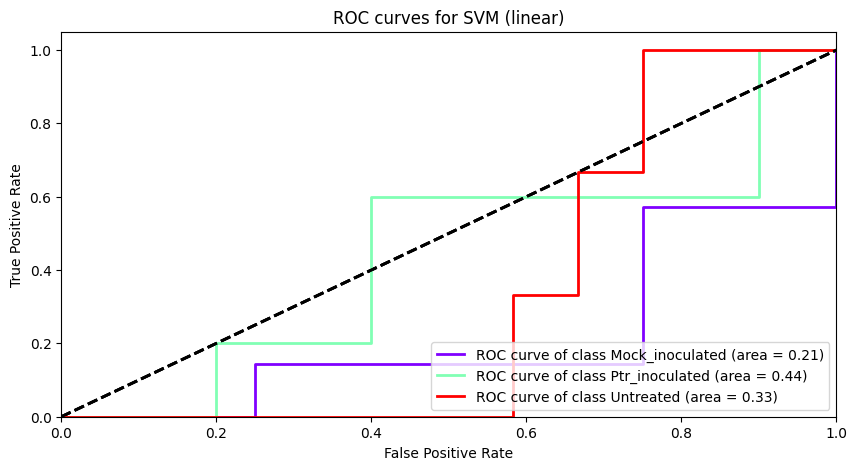

In [45]:
# Call the function by passing top 1000 features and store the roc value separately
roc_auc_svm_1000, f1score_svm_1000 = SVM_model_feature_selection(X_train_1000, X_test_1000)
#roc_auc_svm_1000

## Generalized Linear Model (GLM) Classifier

### Scale the data

In [46]:
# Scale the data
from sklearn import preprocessing
# Scaling is performed on the training and test data
X_train = scale(X_train, axis=1)
X_test = scale(X_test, axis=1)


###GLM classifier

In [47]:
from sklearn.linear_model import LogisticRegression
# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# Train the model
model.fit(X_train, y_train)
# Test the model
predictions = model.predict(X_test)
# Accuracy metrics calculation
c_matrix = confusion_matrix(y_test,predictions)
cr = classification_report(y_test,predictions)
model_accuracy = accuracy_score(y_test, predictions)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


###Accuracy Metrics

In [48]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
c_matrix = confusion_matrix(y_test,predictions)
cr = classification_report(y_test,predictions)
model_accuracy = accuracy_score(y_test, predictions)
f1score_glm_all = f1_score(y_test, predictions, average='weighted')

###Confusion Matrix Plot

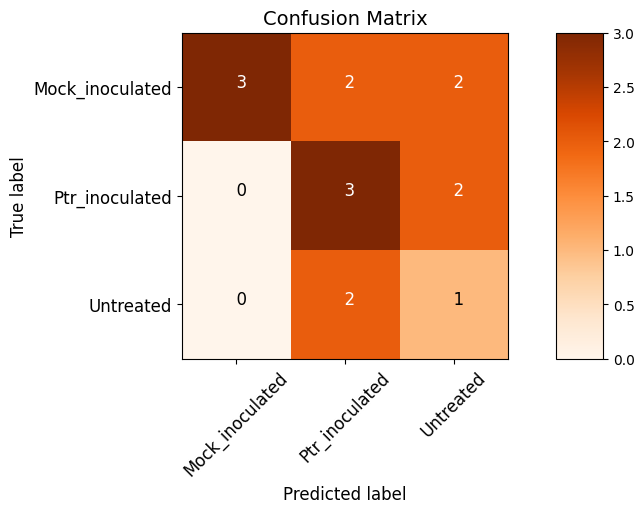

In [49]:
# Plot confusion matrix
plt.figure(figsize = (10, 5))
plt.imshow(c_matrix, cmap=cm.Oranges)
plt.title('Confusion Matrix', size = 14)
plt.colorbar(aspect=7)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45, size = 12)
plt.yticks(tick_marks, classes, size = 12)
fmt = '3d'
thresh = c_matrix.max() / 2.


for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
  plt.text(j, i, format(c_matrix[i, j], fmt), fontsize = 12,
        horizontalalignment='center',
        color='white' if c_matrix[i, j] > thresh else 'black')


#plt.grid(None)
plt.tight_layout()
plt.ylabel('True label', size = 12)
plt.xlabel('Predicted label', size = 12)
plt.show()

###ROC Curve

In [50]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
# to make roc curve we should binarize our class labels to “one hot” vectors, so each class represent binary vector
# for example: first class = [1, 0, 0, 0], second = [0, 1, 0, 0], ...
y_test_bin_labels = label_binarize(y_test, classes=classes)
# for roc curve we are using estimated probability for our test samples
#y_score = model.decision_function(X_test)
y_score = model.predict_proba(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
  fpr[i], tpr[i], _ = roc_curve(y_test_bin_labels[:, i], y_score[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])
roc_auc_glm_all = roc_auc

ROC Curve Plot

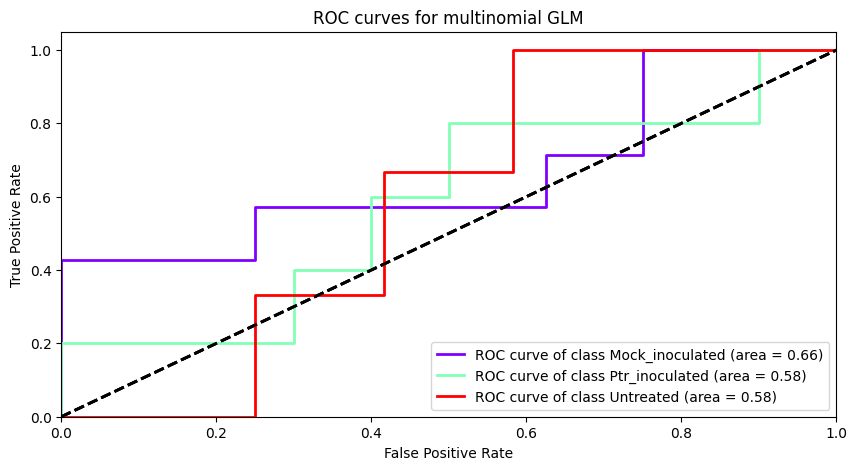

In [51]:
import matplotlib.cm as cm
plt.figure(figsize=(10, 5))
lw = 2
colors = cm.rainbow(np.linspace(0, 1, len(classes)))
for i, color in zip(range(len(classes)), colors):
  plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})' .format(classes[i], roc_auc[i]))
  plt.plot([0, 1], [0, 1], 'k--', lw=lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate', size=10)
  plt.ylabel('True Positive Rate', size=10)
  plt.title('ROC curves for multinomial GLM', size=12)
  plt.legend(loc='lower right')
plt.show()

##GLM with top 15, 100, 1000 features

###Introduction

Following the two cases above, a function is defined to enable multiple calls to estimate GLM classifier's performance for selected (15, 100, 1000) top features as selected by Random Forest algorithm

###Function definition

In [52]:
#Import packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import itertools
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.cm as cm


#Define the function that tests the GLM classifier trained on selected features
#and returns the ROC
def GLM_model_feature_selection(X_train, X_test):

  # Scaling is performed on the training and test data
  X_train = scale(X_train, axis=1)
  X_test = scale(X_test, axis=1)

  # define the multinomial logistic regression model
  model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
  # Train the model
  model.fit(X_train, y_train)
  # Test the model
  predictions = model.predict(X_test)

  # Accuracy metrics calculation
  c_matrix = confusion_matrix(y_test,predictions)
  cr = classification_report(y_test,predictions)
  model_accuracy = accuracy_score(y_test, predictions)
  f1score = f1_score(y_test, predictions, average='weighted')

  #Plot Confusion matrix
  plt.figure(figsize = (10, 5))
  plt.imshow(c_matrix, cmap=cm.Oranges)
  plt.title('Confusion Matrix', size = 14)
  plt.colorbar(aspect=7)
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45, size = 12)
  plt.yticks(tick_marks, classes, size = 12)
  fmt = '3d'
  thresh = c_matrix.max() / 2.


  for i, j in itertools.product(range(c_matrix.shape[0]), range(c_matrix.shape[1])):
    plt.text(j, i, format(c_matrix[i, j], fmt), fontsize = 12,
          horizontalalignment='center',
          color='white' if c_matrix[i, j] > thresh else 'black')


  #plt.grid(None)
  plt.tight_layout()
  plt.ylabel('True label', size = 12)
  plt.xlabel('Predicted label', size = 12)
  plt.show()

  # to make roc curve we should binarize our class labels to “one hot” vectors, so each class represent binary vector
  # for example: first class = [1, 0, 0, 0], second = [0, 1, 0, 0], ...
  y_test_bin_labels = label_binarize(y_test, classes=classes)
  # for roc curve we are using estimated probability for our test samples
  y_score = model.decision_function(X_test)
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin_labels[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  #roc_auc_svm_30 = roc_auc

  plt.figure(figsize=(10, 5))
  lw = 2
  colors = cm.rainbow(np.linspace(0, 1, len(classes)))
  for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw, label='ROC curve of class {0} (area = {1:0.2f})' .format(classes[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', size=10)
    plt.ylabel('True Positive Rate', size=10)
    plt.title('ROC curves for multinomial GLM', size=12)
    plt.legend(loc='lower right')
  plt.show()
  return roc_auc, f1score

###GLM with top 15 features

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: 

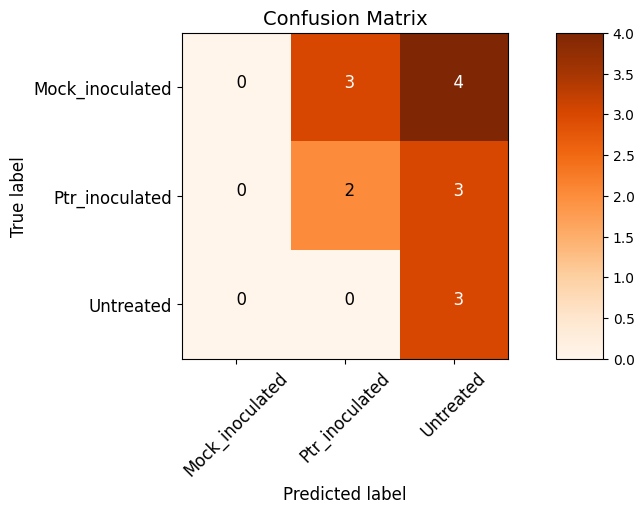

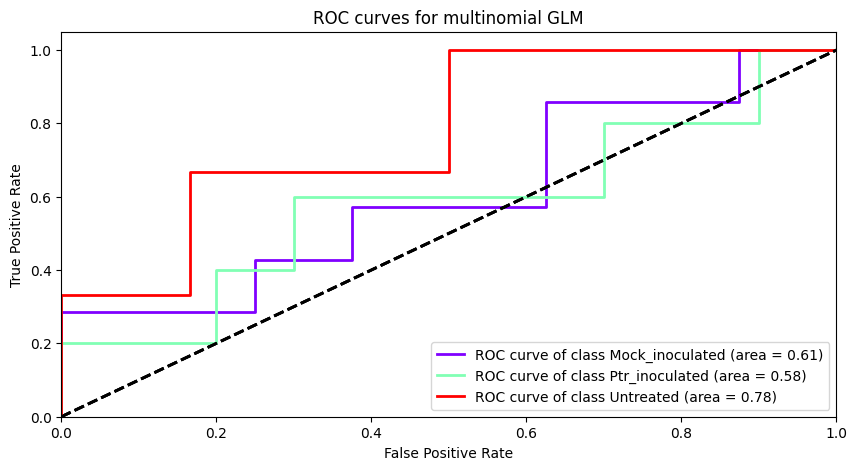

In [53]:
# Call the function by passing top 15 features and store the roc value separately
roc_auc_glm_15, f1score_glm_15 = GLM_model_feature_selection(X_train_15, X_test_15)
#roc_auc_glm_15

###GLM with top 100 features

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisi

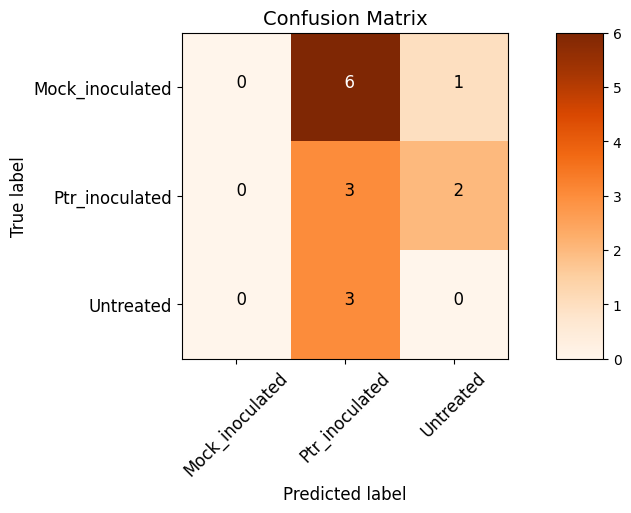

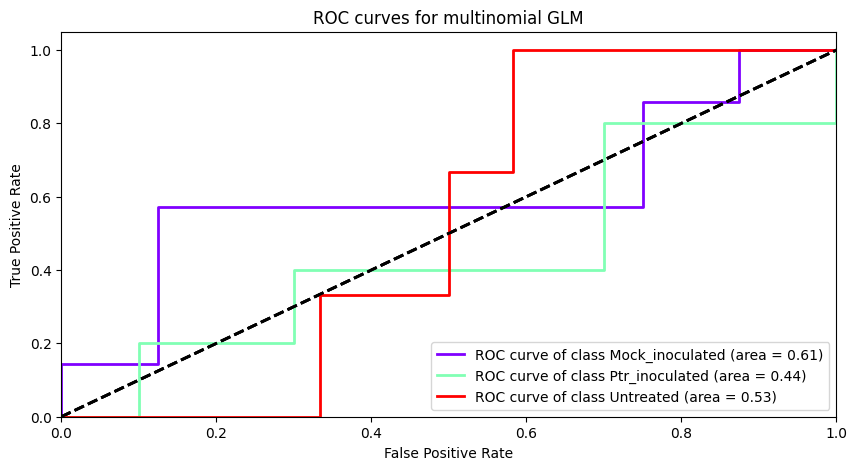

In [54]:
# Call the function by passing top 100 features and store the roc value separately
roc_auc_glm_100, f1score_glm_100 = GLM_model_feature_selection(X_train_100, X_test_100)
#roc_auc_glm_100

###GLM with top 1000 features

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


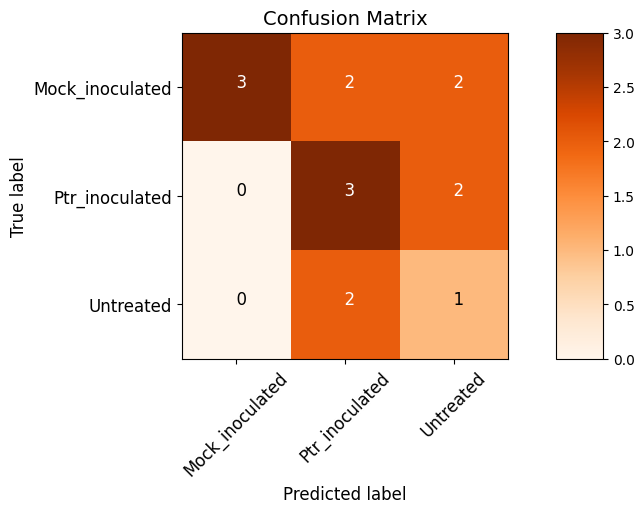

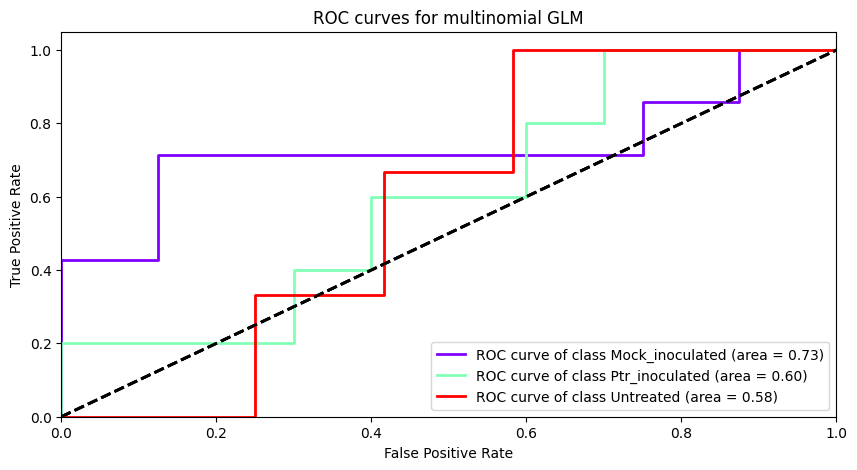

In [55]:
# Call the function by passing top 10 features and store the roc value separately
roc_auc_glm_1000, f1score_glm_1000 = GLM_model_feature_selection(X_train_1000, X_test_1000)
#roc_auc_glm_1000

##Comparison of ROC Area under Curve between SVM (linear), Random Forest and GLM models.

In [60]:
##Compile ROC values of the classifiers
roc_auc_svm = pd.DataFrame({'svm15':roc_auc_svm_15,
                            'svm100':roc_auc_svm_100,
                            'svm1000':roc_auc_svm_1000,
                            'svmN':roc_auc_svm_all})

roc_auc_rf = pd.DataFrame({'rf15':roc_auc_rf_15,
                            'rf100':roc_auc_rf_100,
                            'rf1000':roc_auc_rf_1000,
                            'rfN':roc_auc_rf_all})

roc_auc_glm = pd.DataFrame({'glm15':roc_auc_glm_15,
                            'glm100':roc_auc_glm_100,
                            'glm1000':roc_auc_glm_1000,
                            'glmN':roc_auc_glm_all})

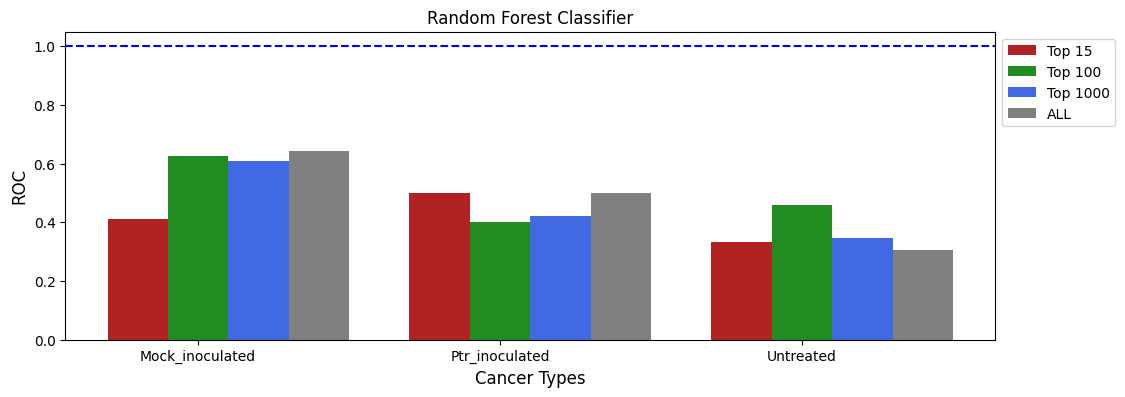

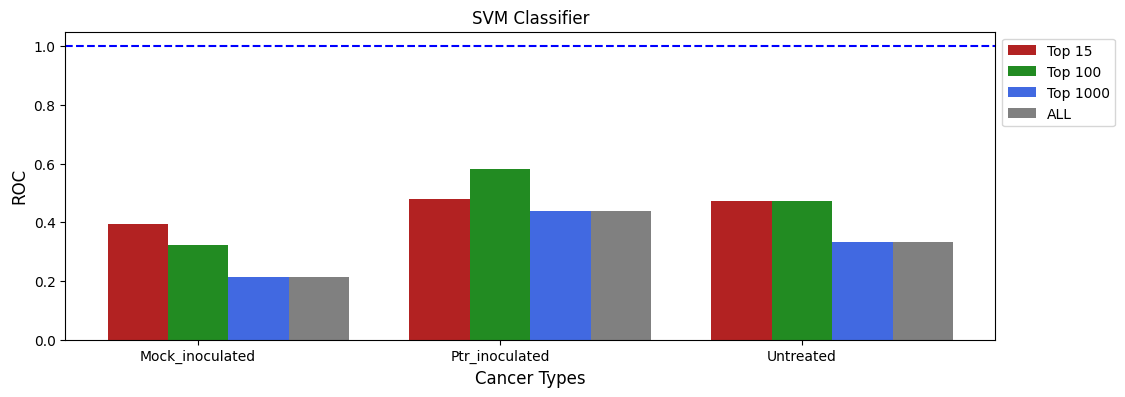

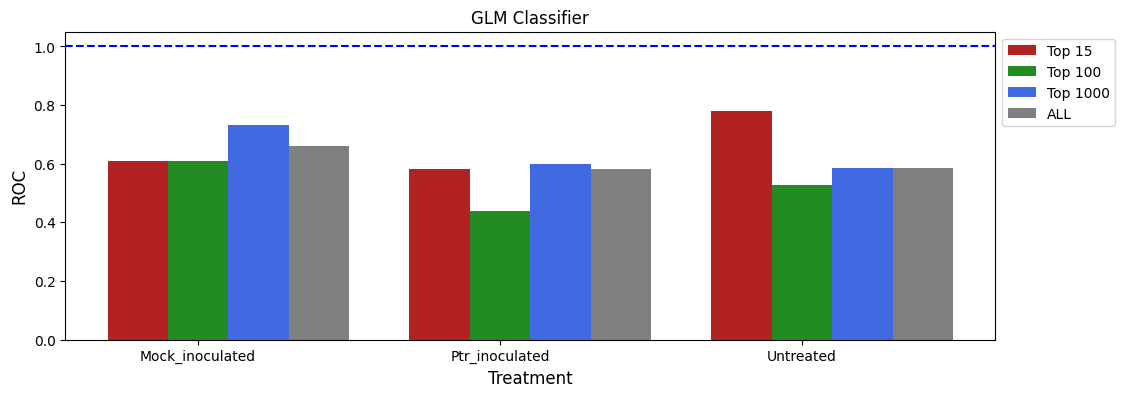

In [62]:
## Plot the ROC results by type of classifier
N = len(classes)
ind = np.arange(N)
width = 0.20

### RF plot
plt.figure(figsize=(12,4))
bar1 = plt.bar(ind, roc_auc_rf['rf15'], width, color = 'firebrick')
bar2 = plt.bar(ind+width, roc_auc_rf['rf100'], width, color='forestgreen')
bar3 = plt.bar(ind+width*2, roc_auc_rf['rf1000'], width, color = 'royalblue')
bar4 = plt.bar(ind+width*3, roc_auc_rf['rfN'], width, color = 'grey')

plt.xlabel("Cancer Types", size=12)
plt.ylabel('ROC', size=12)
plt.axhline(y = 1, color = 'b', linestyle = '--')
plt.title("Random Forest Classifier", size=12)

plt.xticks(ind+width,classes)
plt.legend((bar1, bar2, bar3, bar4), ('Top 15', 'Top 100', 'Top 1000', 'ALL'), bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

### SVM plot
plt.figure(figsize=(12,4))
bar1 = plt.bar(ind, roc_auc_svm['svm15'], width, color = 'firebrick')
bar2 = plt.bar(ind+width, roc_auc_svm['svm100'], width, color='forestgreen')
bar3 = plt.bar(ind+width*2, roc_auc_svm['svm1000'], width, color = 'royalblue')
bar4 = plt.bar(ind+width*3, roc_auc_svm['svmN'], width, color = 'grey')

plt.xlabel("Cancer Types", size=12)
plt.ylabel('ROC', size=12)
plt.axhline(y = 1, color = 'b', linestyle = '--')
plt.title("SVM Classifier", size=12)

plt.xticks(ind+width,classes)
plt.legend((bar1, bar2, bar3, bar4), ('Top 15', 'Top 100', 'Top 1000', 'ALL'), bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

### GLM plot
plt.figure(figsize=(12,4))
bar1 = plt.bar(ind, roc_auc_glm['glm15'], width, color = 'firebrick')
bar2 = plt.bar(ind+width, roc_auc_glm['glm100'], width, color='forestgreen')
bar3 = plt.bar(ind+width*2, roc_auc_glm['glm1000'], width, color = 'royalblue')
bar4 = plt.bar(ind+width*3, roc_auc_glm['glmN'], width, color = 'grey')

plt.xlabel("Treatment", size=12)
plt.ylabel('ROC', size=12)
plt.axhline(y = 1, color = 'b', linestyle = '--')
plt.title("GLM Classifier", size=12)

plt.xticks(ind+width,classes)
plt.legend((bar1, bar2, bar3, bar4), ('Top 15', 'Top 100', 'Top 1000', 'ALL'), bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


# Interpretation of Classifier Performance

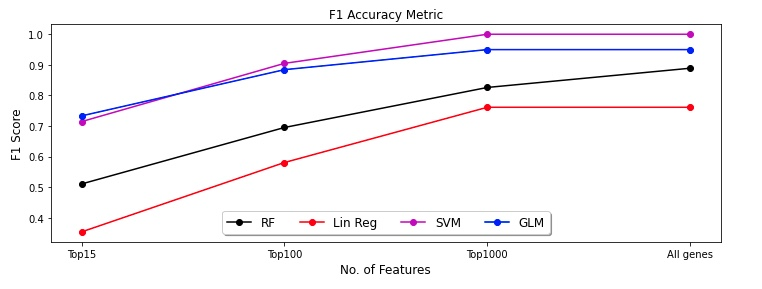


Since ROC is impossible to calculate for Linear Regression, we have prepared ROC metrics for 3 other models, RF, SVM and GLM. However, looking just at this metric, we can tell that RF is performing the nbest across all sets of features for all classes. This is expected since we used RF to select features.

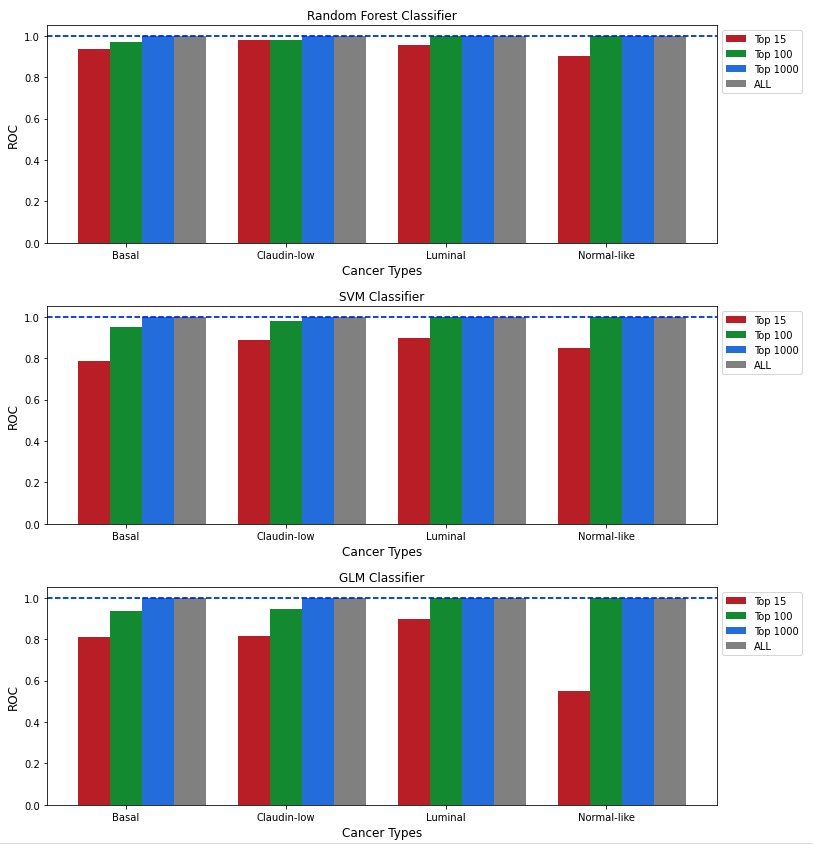

Then the comparison between SVM and GLM  reveals that both models perform similarly in overall accuracy, however Normal-Like class which has only 1 sample in the test data used for prediction performs much worse in GLM with 15 genes only. Also, it performs worse in Claudin-Low class with 15 genes only.
